## 뉴욕시의 Taxi 데이터 활용한 예측 모델
    - dataset : 케글의 NYC_Taxi
    - 거리에 따른 택시요금 예측
    - 조건) 뉴욕시 내에서 승차/하차의 경우만
    - 조건 : 뉴욕시 내

##### [1] 데이터 로딩

In [149]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# 전체데이터
# file=pd.read_csv('C:/Users/user/Desktop/머신러닝/NYC_Taxi/train.csv')

In [109]:
# nrows = 원하는 행 수 --> 원하는 만큼만 데이터 로딩
# parse_dates = ['컬럼명'] --> 데이터를 가져오면서 datatime으로 형변환
df=pd.read_csv('C:/Users/user/Desktop/머신러닝/NYC_Taxi/train.csv', 
nrows=50000, parse_dates=['pickup_datetime'])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                50000 non-null  object             
 1   fare_amount        50000 non-null  float64            
 2   pickup_datetime    50000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   50000 non-null  float64            
 4   pickup_latitude    50000 non-null  float64            
 5   dropoff_longitude  50000 non-null  float64            
 6   dropoff_latitude   50000 non-null  float64            
 7   passenger_count    50000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 3.1+ MB
None


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [110]:
df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

##### [2] 결측치 및 이상치 체크

In [111]:
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [112]:
df.describe()
# 요금이 마이너스(-), 승객이 0명?
# 결측치가 없다고 이상치가 없는 것은 아님.

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734372,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


In [113]:
# 뉴욕으로 한정
df = df[(df["pickup_longitude"] <= -71.47) & (df["pickup_longitude"] >= -79.45)]
df = df[(df["pickup_latitude"] >= 40.29) & (df["pickup_latitude"] <= 45)]
df = df[(df["dropoff_longitude"] <= -71.47) & (df["dropoff_longitude"] >= -79.45)]
df = df[(df["dropoff_latitude"] >= 40.29) & (df["dropoff_latitude"] <= 45)]

##### 결측치 처리

In [114]:
df= df[df['fare_amount'] > 0]
df = df[df['passenger_count'] > 0]

### 특성 새롭게 생성 => 거리(Feature : distance)
- 공식 : $ \sqrt{(x2 - x1)^2 + (y2-y1)^2} $

In [115]:
# distance = ((df.pickup_latitude - df.dropoff_latitude)**2 + (df.pickup_longitude - df.dropoff_latitude)**2)*0.5
df['distance'] = (((df['pickup_longitude'] - df['dropoff_longitude']) ** 2 + (df['pickup_latitude'] - df['dropoff_latitude']) ** 2) ** 0.5) 

df=df[df.distance > 0]

In [116]:
print(df.isnull().sum())
df.describe()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
distance             0
dtype: int64


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,48255.000000,48255.000000,48255.000000,48255.000000,48255.000000,48255.000000,4.825500e+04
mean,11.367828,-73.975478,40.751175,-73.974269,40.751641,1.676158,3.485239e-02
std,9.559983,0.038775,0.031736,0.037119,0.034921,1.290360,4.277905e-02
min,0.010000,-75.423848,40.307765,-75.354559,40.316153,1.000000,1.000000e-06
25%,6.000000,-73.992328,40.736529,-73.991340,40.735933,1.000000,1.314358e-02
50%,8.500000,-73.982141,40.753467,-73.980515,40.754148,1.000000,2.210121e-02
75%,12.500000,-73.968515,40.767798,-73.965510,40.768516,2.000000,3.937218e-02
max,200.000000,-72.856968,43.098708,-72.854940,43.415190,6.000000,1.451283e+00


In [117]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.009436
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,0.079696
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.013674
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,0.025340
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,0.019470


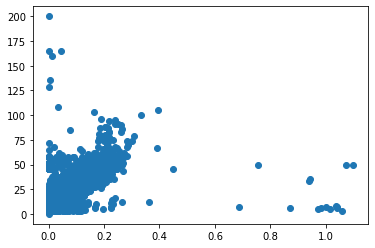

In [126]:
plt.scatter(train_x, train_y)

In [118]:
# 거리(x)에 따른 요금(y)

fare_amount=np.array(df.fare_amount)
distance=np.array(df.distance)

fare_amount=fare_amount.reshape(-1,1)
distance=distance.reshape(-1,1)

train_x, test_x, train_y, test_y = train_test_split(distance, fare_amount, random_state=42, test_size=0.2)

In [125]:
train_poly = np.column_stack((train_x**2, train_x))
test_poly = np.column_stack((test_x**2, test_x))

In [121]:
lr = LinearRegression()
lr.fit(train_poly, train_y)
# print(lr.score(train_x, train_y))
# print(lr.score(test_x, test_y))
print(lr.coef_, lr.intercept_)

[[-237.05841833  258.39167628]] [3.06252802]


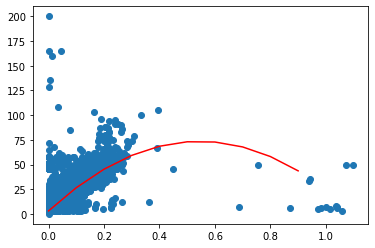

In [133]:
point=np.arange(0.0, 1.0, 0.1)

plt.scatter(train_x, train_y)
plt.plot(point,-237.05841833*point**2 + 258.39167628*point +3.06252802, color='red')

In [136]:
# 이상치 제거
df=df[(df['distance']<0.3) & (df['fare_amount']<100)]

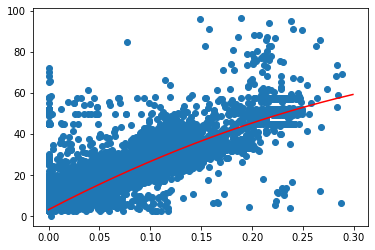

In [139]:
# 제거하고 다시

fare_amount=np.array(df.fare_amount)
distance=np.array(df.distance)

fare_amount=fare_amount.reshape(-1,1)
distance=distance.reshape(-1,1)

train_x, test_x, train_y, test_y = train_test_split(distance, fare_amount, random_state=42, test_size=0.2)

point=np.arange(0, 0.3, 0.001)

plt.scatter(train_x, train_y)
plt.plot(point,-237.05841833*point**2 + 258.39167628*point +3.06252802, color='red')

#### 당뇨

In [144]:
diabetes_df=pd.read_csv('C:/Users/user/Desktop/머신러닝/diabetes.csv')
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [145]:
diabetes_df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [146]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [147]:
diabetes_df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [148]:
# 학습, 테스트 데이터 분리
train_input, test_input, train_target, test_target = train_test_split(
    diabetes_df[['Glucose', 'BMI', 'Age']], diabetes_df['Outcome'], random_state=42, test_size=0.4)

In [153]:
logi = LogisticRegression()
logi.fit(train_input, train_target)
print(logi.coef_, logi.intercept_)

[[0.03121652 0.10351195 0.04206972]] [-9.29999316]


In [161]:
preY=logi.predict_proba([[30,50,100]])
print('당뇨 O :', preY[0][0])
print('당뇨 X :', preY[0][1])

당뇨 O : 0.2652082191558519
당뇨 X : 0.7347917808441481


c:\ProgramData\Miniconda3\envs\EV_PY39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
